<a href="https://colab.research.google.com/github/DVORA-AZARKOVICH/Narrative-Similarity/blob/main/NarrativeSimilarityA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Narrative Similarity Task**

The Problem (Track A)Track A is a binary classification task where the system must determine which of two candidate stories, A or B, is more similar in narrative content to a given anchor story (speech transcript).

The goal is to predict if $\text{Similarity}(Anchor, A) > \text{Similarity}(Anchor, B)$.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The synthetic dataset is used for training**

**The develop dataset is used for validation**

In [ ]:
import pandas as pd
import json

BASE_PATH = '/content/drive/MyDrive/Narrative Similarity Data/'

SYNTHETIC_FILE = BASE_PATH + 'synthetic_data_for_classification.jsonl'
df_synthetic = pd.read_json(SYNTHETIC_FILE, lines=True)
print("--- Synthetic Data Loaded ---")
print(f"Shape: {df_synthetic.shape}")

DEV_FILE = BASE_PATH + 'SemEval2026-Task_4-dev-v1/dev_track_a.jsonl'
df_dev = pd.read_json(DEV_FILE, lines=True)
print("\n--- Development Data Loaded ---")
print(f"Shape: {df_dev.shape}")


--- Synthetic Data Loaded ---
Shape: (1900, 5)

--- Development Data Loaded ---
Shape: (200, 4)


In [ ]:
print("\n--- Column Names for Synthetic Data (Must match Dev data) ---")
print(df_synthetic.columns)

print("\n--- Dtypes Check ---")
print(df_synthetic.dtypes)


--- Column Names for Synthetic Data (Must match Dev data) ---
Index(['model_name', 'anchor_text', 'text_a', 'text_b', 'text_a_is_closer'], dtype='object')

--- Dtypes Check ---
model_name          object
anchor_text         object
text_a              object
text_b              object
text_a_is_closer      bool
dtype: object


In [ ]:
print("\n--- Column Names for Synthetic Data (Must match Dev data) ---")
print(df_dev.columns)

print("\n--- Dtypes Check ---")
print(df_dev.dtypes)


--- Column Names for Synthetic Data (Must match Dev data) ---
Index(['anchor_text', 'text_a', 'text_b', 'text_a_is_closer'], dtype='object')

--- Dtypes Check ---
anchor_text         object
text_a              object
text_b              object
text_a_is_closer      bool
dtype: object


In [ ]:
df_synthetic = df_synthetic.drop(columns=['model_name'])

df_train = df_synthetic.copy()

This script defines a clean_text function using NLTK and regular expressions to standardize textual data. The function converts text to lowercase, removes punctuation, eliminates common stopwords, and performs lemmatization to reduce words to their base form. Finally, it applies this cleaning process to specified text columns in both training (df_train) and development (df_dev) datasets for model preparation.

In [ ]:
df_train['len_anchor_words'] = df_train['anchor_text'].apply(lambda x: len(str(x).split()))
df_train['len_a_words'] = df_train['text_a'].apply(lambda x: len(str(x).split()))
df_train['len_b_words'] = df_train['text_b'].apply(lambda x: len(str(x).split()))

print(df_train[['len_anchor_words', 'len_a_words', 'len_b_words']].describe())

       len_anchor_words  len_a_words  len_b_words
count       1900.000000  1900.000000  1900.000000
mean         147.563158   157.825789   158.143684
std           31.857514    32.802530    32.671984
min            1.000000     1.000000     1.000000
25%          129.000000   140.000000   141.000000
50%          149.000000   158.000000   158.000000
75%          169.000000   178.000000   179.000000
max          249.000000   254.000000   254.000000


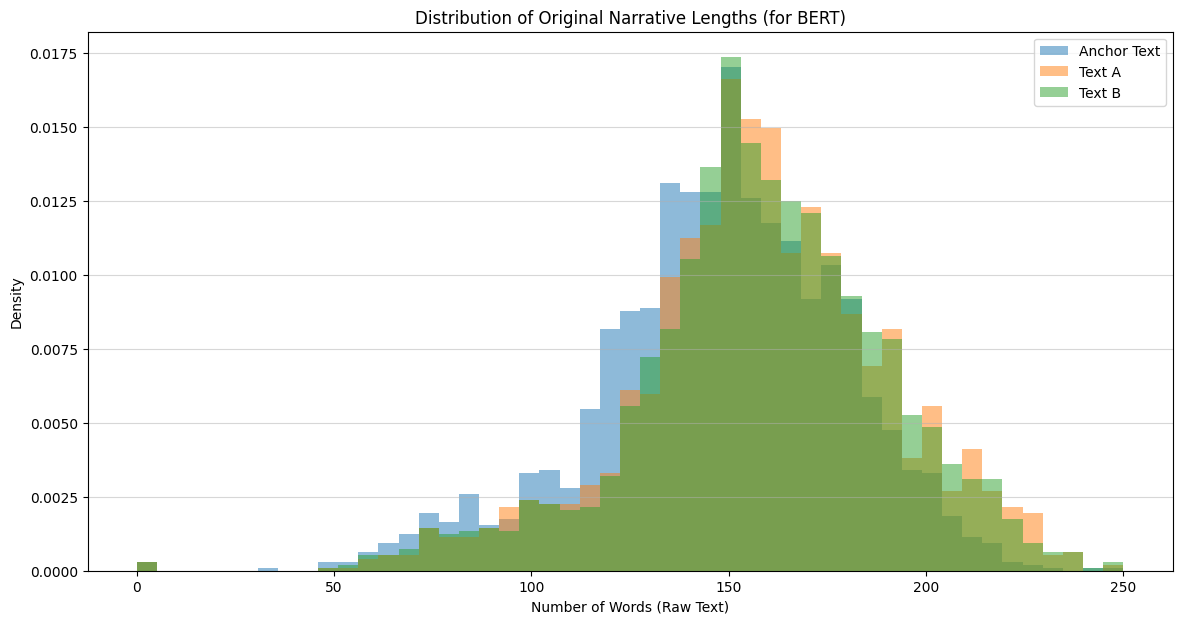

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_train['len_anchor_words'] = df_train['anchor_text'].apply(lambda x: len(str(x).split()))
df_train['len_a_words'] = df_train['text_a'].apply(lambda x: len(str(x).split()))
df_train['len_b_words'] = df_train['text_b'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(14, 7))

bins = np.linspace(0, 250, 50)

plt.hist(df_train['len_anchor_words'], bins=bins, alpha=0.5, label='Anchor Text', density=True)
plt.hist(df_train['len_a_words'], bins=bins, alpha=0.5, label='Text A', density=True)
plt.hist(df_train['len_b_words'], bins=bins, alpha=0.5, label='Text B', density=True)

plt.title('Distribution of Original Narrative Lengths (for BERT)')
plt.xlabel('Number of Words (Raw Text)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

The graph shows that all three types of narratives (Anchor Text, Text A, and Text B) have an identical length distribution (peaking around 20-40 words), indicating high consistency in the data source. The key conclusion is that there is no significant length bias in the dataset. This allows the similarity model to focus solely on semantic differences and content, without needing to neutralize structural gaps between the summaries.

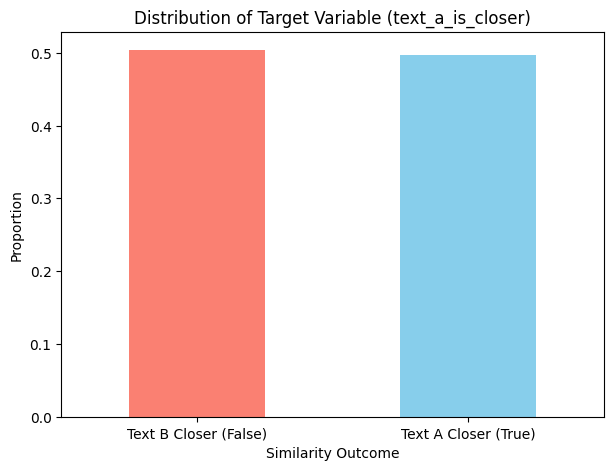

In [ ]:

plt.figure(figsize=(7, 5))
df_train['text_a_is_closer'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Distribution of Target Variable (text_a_is_closer)')
plt.xticks([0, 1], ['Text B Closer (False)', 'Text A Closer (True)'], rotation=0)
plt.ylabel('Proportion')
plt.xlabel('Similarity Outcome')
plt.show()

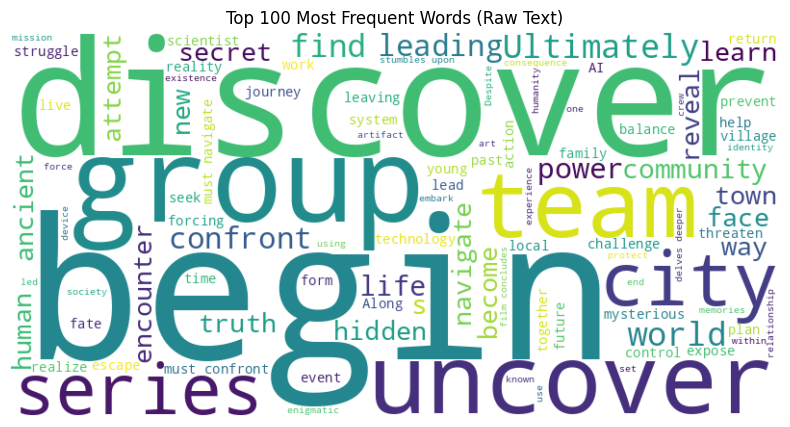

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

all_text = ' '.join(pd.concat([
    df_train['anchor_text'],
    df_train['text_a'],
    df_train['text_b']
]).astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    stopwords=STOPWORDS
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words (Raw Text)')
plt.show()

In [ ]:
import re

def clean_text_for_bert(text):
    text = str(text)
    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()


    return text

print("Starting Minimal Text Cleaning for BERT...")
text_cols = ['anchor_text', 'text_a', 'text_b']

for col in text_cols:
    df_train[f'clean_{col}'] = df_train[col].apply(clean_text_for_bert)
    df_dev[f'clean_{col}'] = df_dev[col].apply(clean_text_for_bert)

print("\n--- Minimal Text Cleaning Complete! ---")
print(df_train[['text_a', 'clean_text_a']].head(2))

Starting Minimal Text Cleaning for BERT...

--- Minimal Text Cleaning Complete! ---
                                              text_a  \
0  In the coastal city of Tidal Cove, a reclusive...   
1  In a sprawling, rain-soaked city, a quiet mech...   

                                        clean_text_a  
0  in the coastal city of tidal cove, a reclusive...  
1  in a sprawling, rain-soaked city, a quiet mech...  


#Sentiment Analysis - VADER
The text_a_is_closer column is the Ground Truth (True/False) for which story is narratively more similar to the anchor.
The sentiment_ columns show the VADER Compound Score (ranging from $-1.0$ to $+1.0$), which measures the overall emotional tone of each narrative.These sentiment scores provide the model with a crucial narrative feature to identify emotional similarity between story plots, supplementing the BERT embeddings.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    nltk.download('vader_lexicon', quiet=True)
except Exception:
    pass

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(str(text))['compound']

sentiment_cols = ['anchor_text', 'text_a', 'text_b']

print("Generating Sentiment features for Training Data...")
for col in sentiment_cols:
    df_train[f'sentiment_{col}'] = df_train[col].apply(get_sentiment_score)

print("Generating Sentiment features for Development Data...")
for col in sentiment_cols:
    df_dev[f'sentiment_{col}'] = df_dev[col].apply(get_sentiment_score)

print("\n--- Sentiment Feature Generation Complete ---")
print(df_train[['text_a_is_closer', 'sentiment_anchor_text', 'sentiment_text_a', 'sentiment_text_b']].head())

Generating Sentiment features for Training Data...
Generating Sentiment features for Development Data...

--- Sentiment Feature Generation Complete ---
   text_a_is_closer  sentiment_anchor_text  sentiment_text_a  sentiment_text_b
0             False                -0.8658           -0.3013           -0.3818
1             False                -0.9460           -0.8765           -0.7003
2             False                -0.8807           -0.5267           -0.9741
3              True                -0.8555           -0.6808           -0.9610
4              True                -0.9246           -0.6597            0.7003


זיהוי הישויות (Named Entity Recognition - NER)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 132.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


NER is an NLP task that identifies and classifies key information in text, such as PERSONS, LOCATIONS, or ORGANIZATIONS (like the CARDINAL number you saw).

Your output lists the raw counts and types of these fundamental narrative components for each story, like 3 PERSONS in Text A versus a mix of PERSONS and FACILITIES in Text B.

By comparing these entity count vectors, your model gains a structural feature to assess narrative similarity based on the shared "Who" and "What" elements of the story.

In [ ]:
import pandas as pd
import spacy
from collections import Counter

# טעינת המודל
try:
    nlp = spacy.load('en_core_web_sm')
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

def get_entity_counts(text):
    """
    מבצע את מה שהקוד שלך עשה (חילוץ ישויות),
    אבל מחזיר מילון של ספירות במקום רשימה.
    למשל: {'PERSON': 2, 'ORG': 1}
    """
    doc = nlp(str(text))
    # ספירת התוויות (Labels) במקום הטקסט עצמו
    counts = Counter([ent.label_ for ent in doc.ents])
    return dict(counts)

text_cols = ['anchor_text', 'text_a', 'text_b']

print("Generating NER features for entire dataset...")

# לולאה שרצה על כל העמודות ומוסיפה את הפיצ'רים ל-DataFrame
for col in text_cols:
    print(f"Processing column: {col}...")

    # 1. הפעלת הפונקציה על ה-Train
    train_entity_data = df_train[col].apply(get_entity_counts)
    # המרה לטבלה וחיבור לדאטה המקורי
    train_ner_df = pd.DataFrame(train_entity_data.tolist()).fillna(0).astype(int)
    train_ner_df = train_ner_df.add_prefix(f'ner_{col}_')
    df_train = pd.concat([df_train, train_ner_df], axis=1)

    # 2. הפעלת הפונקציה על ה-Dev
    dev_entity_data = df_dev[col].apply(get_entity_counts)
    # המרה לטבלה וחיבור לדאטה המקורי
    dev_ner_df = pd.DataFrame(dev_entity_data.tolist()).fillna(0).astype(int)
    dev_ner_df = dev_ner_df.add_prefix(f'ner_{col}_')
    df_dev = pd.concat([df_dev, dev_ner_df], axis=1)

# --- שלב קריטי: יישור עמודות (Alignment) ---
# ייתכן שישויות מסוימות הופיעו ב-Train ולא ב-Dev (ולהפך).
# אנחנו ממלאים ב-0 את העמודות החסרות כדי למנוע שגיאות בהמשך.

ner_cols = [c for c in df_train.columns if c.startswith('ner_')]
for col in ner_cols:
    if col not in df_dev.columns:
        df_dev[col] = 0

# (אותו דבר הפוך - אם יש משהו ב-Dev שאין ב-Train)
dev_ner_cols = [c for c in df_dev.columns if c.startswith('ner_')]
for col in dev_ner_cols:
    if col not in df_train.columns:
        df_train[col] = 0

print("\nSuccess! NER features added to df_train and df_dev.")
print("New columns example:", df_train.filter(like='ner_').columns[:5].tolist())

Generating NER features for entire dataset...
Processing column: anchor_text...
Processing column: text_a...
Processing column: text_b...

Success! NER features added to df_train and df_dev.
New columns example: ['ner_anchor_text_WORK_OF_ART', 'ner_anchor_text_GPE', 'ner_anchor_text_ORG', 'ner_anchor_text_PERSON', 'ner_anchor_text_DATE']


##Bert Embedding

The transformers library by Hugging Face is the essential tool for working with state-of-the-art language models like BERT, allowing users to easily load pre-trained models and tokenizers for various NLP tasks.

In [ ]:
print("Installing transformers library...")
!pip install transformers
print("Transformers library installed successfully.")

Installing transformers library...
Transformers library installed successfully.


The torch (PyTorch) library is the fundamental deep learning framework used by the transformers library to efficiently handle the complex tensor operations required by the BERT model.

In [ ]:
print("Installing torch library (CPU version)...")
!pip install torch
print("Torch library installed successfully.")

Installing torch library (CPU version)...
Torch library installed successfully.


## Load BERT Model


In [ ]:
from transformers import BertTokenizer

# 2. הגדרת הנתיב המבוקש
OUTPUT_PATH = '/content/drive/MyDrive/Narrative Similarity Data/bert_embeddings/'


# 3. הגדרות וטוקנייזר
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

# זיהוי עמודות הפיצ'רים ההנדסיים לשמירה (NER + Sentiment)
sentiment_cols = [c for c in df_train.columns if c.startswith('sentiment_')]
ner_cols = [c for c in df_train.columns if c.startswith('ner_') and c != 'ner_only_prediction']
engineered_features = sentiment_cols + ner_cols

# 4. פונקציות עזר (ניקוי וטוקניזציה)

def clean_column_for_tokenizer(df, col_name):
    """ממיר את העמודה ל-string ומטפל בערכים חסרים"""
    return df[col_name].fillna("").astype(str)

def tokenize_data(texts):
    """מבצע טוקניזציה ומחזיר רשימות"""
    encoding = tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )
    # המרה לרשימות רגילות כדי למנוע שגיאות ממדים בפנדס
    return encoding['input_ids'].tolist(), encoding['attention_mask'].tolist()

print("Preparing data...")

# 5. ניקוי מקדים (הופך הכל למחרוזות)
text_cols = ['anchor_text', 'text_a', 'text_b']
for col in text_cols:
    df_train[col] = clean_column_for_tokenizer(df_train, col)
    df_dev[col] = clean_column_for_tokenizer(df_dev, col)

print(f"Tokenizing data with Max Length: {MAX_LEN}...")

# 6. ביצוע הטוקניזציה (Train)
input_ids, attention_mask = tokenize_data(df_train['anchor_text'])
df_train['anchor_ids'] = input_ids
df_train['anchor_mask'] = attention_mask

input_ids, attention_mask = tokenize_data(df_train['text_a'])
df_train['text_a_ids'] = input_ids
df_train['text_a_mask'] = attention_mask

input_ids, attention_mask = tokenize_data(df_train['text_b'])
df_train['text_b_ids'] = input_ids
df_train['text_b_mask'] = attention_mask

# ביצוע הטוקניזציה (Dev)
input_ids, attention_mask = tokenize_data(df_dev['anchor_text'])
df_dev['anchor_ids'] = input_ids
df_dev['anchor_mask'] = attention_mask

input_ids, attention_mask = tokenize_data(df_dev['text_a'])
df_dev['text_a_ids'] = input_ids
df_dev['text_a_mask'] = attention_mask

input_ids, attention_mask = tokenize_data(df_dev['text_b'])
df_dev['text_b_ids'] = input_ids
df_dev['text_b_mask'] = attention_mask

print("Tokenization complete.")

# 7. שמירה כ-Pickle בנתיב החדש

cols_to_keep = [
    'anchor_ids', 'anchor_mask',
    'text_a_ids', 'text_a_mask',
    'text_b_ids', 'text_b_mask',
    'text_a_is_closer'
] + engineered_features

# וידוא שהלייבל הוא מספרי (0/1)
df_train['text_a_is_closer'] = df_train['text_a_is_closer'].astype(int)
df_dev['text_a_is_closer'] = df_dev['text_a_is_closer'].astype(int)

train_pkl_path = OUTPUT_PATH + 'train_tokenized.pkl'
dev_pkl_path = OUTPUT_PATH + 'dev_tokenized.pkl'

df_train[cols_to_keep].to_pickle(train_pkl_path)
df_dev[cols_to_keep].to_pickle(dev_pkl_path)

print(f"\n✅ Tokenized data saved successfully to Drive:\n - {train_pkl_path}\n - {dev_pkl_path}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Preparing data...
Tokenizing data with Max Length: 128...
Tokenization complete.

✅ Tokenized data saved successfully to Drive:
 - /content/drive/MyDrive/Narrative Similarity Data/bert_embeddings/train_tokenized.pkl
 - /content/drive/MyDrive/Narrative Similarity Data/bert_embeddings/dev_tokenized.pkl


The Narrative Similarity Task dataset is a collection of story summaries, with the core annotated data (just over 1000 triples) being sourced from Wikipedia. This data was prepared for the SemEval-2026 Task 4. A primary limitation is that while it includes a small set of human-annotated examples, it is heavily augmented by a larger volume (1900 triples) of synthetic training data generated by Large Language Models (LLMs). The dataset primarily represents story narratives as summarized in an English-language, encyclopedic context (Wikipedia articles). Consequently, it does not explicitly document or capture specific demographic groups of human narrators or participants, but rather the broad, general population of narratives that have been summarized and cataloged on the platform.